**Prediction of Tsunami Risk Due to Earthquakes in Indonesia**

Link to Dataset: [here](https://drive.google.com/file/d/1IoSvP6NUhIASIVhujHtVIIU-WVcJKMt6/view?usp=sharing)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point
!pip install contextily
import contextily as ctx
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from folium.plugins import MarkerCluster


file_path = "/content/Gempa_Dataset.csv"
df = pd.read_csv(file_path)


print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)
df.head()


Shape of the dataset: (116999, 11)
Columns in the dataset: Index([' eventID', 'datetime', 'latitude', 'longitude', 'magnitude',
       'mag_type', 'depth', 'phasecount', 'azimuth_gap', 'location', 'agency'],
      dtype='object')


eventID                          datetime  latitude   longitude  \
0  bmg2008vkye  2008-11-01 00:31:25.143741+00:00 -0.604440   98.895531   
1  bmg2008vlag  2008-11-01 01:34:29.660856+00:00 -6.611860  129.387220   
2  bmg2008vlaj  2008-11-01 01:38:14.802129+00:00 -3.650586  127.990680   
3  bmg2008vlbt  2008-11-01 02:20:05.909515+00:00 -4.198925  128.097000   
4  bmg2008vlcd  2008-11-01 02:32:18.756155+00:00 -4.091891  128.200470   

   magnitude mag_type  depth  phasecount  azimuth_gap  \
0   2.989742      MLv     20         6.0    146.70738   
1   5.507549       mb     30        62.0     45.46764   
2   3.539674      MLv      5         4.0    331.97404   
3   2.424314      MLv      5         5.0    326.37993   
4   2.410045      MLv     10         5.0    314.65474   

                      location agency  
0  Southern Sumatra, Indonesia    NaN  
1                    Banda Sea    NaN  
2             Seram, Indonesia    NaN  
3                    Banda Sea    NaN  
4                    Banda Sea    NaN

**Handle Missing Values**

In [ ]:
# Impute missing values in 'magnitude' and 'depth' with median
df['magnitude'] = df['magnitude'].fillna(df['magnitude'].median())
df['depth'] = df['depth'].fillna(df['depth'].median())

# If location is critical, consider replacing missing values with 'Unknown' or imputing based on nearby rows
df['location'] = df['location'].fillna('Unknown')

# Fill missing values for other columns as before
df['agency'] = df['agency'].fillna('BMKG')
df['phasecount'] = df['phasecount'].fillna(df['phasecount'].median())
df['azimuth_gap'] = df['azimuth_gap'].fillna(df['azimuth_gap'].median())


**Feature Engineering**

In [ ]:
# Create a new binary target column 'tsunami'
df['tsunami'] = np.where((df['magnitude'] >= 6.0) & (df['depth'] <= 30), 1, 0)


In [ ]:
# Define risk levels
def assign_risk(magnitude, depth):
    if magnitude >= 7.0 and depth <= 20:
        return "High"
    elif magnitude >= 6.0 and depth <= 30:
        return "Medium"
    else:
        return "Low"

# Apply the function to create a new column for risk levels
df['risk_level'] = df.apply(lambda x: assign_risk(x['magnitude'], x['depth']), axis=1)

# Sort data based on risk level (High > Medium > Low), high magnitude (descending), and shallow depth (ascending)
def risk_level_key(level):
    return {"High": 0, "Medium": 1, "Low": 2}[level]

df = df.sort_values(by=['risk_level', 'magnitude', 'depth'],
                    key=lambda col: col.map(risk_level_key) if col.name == 'risk_level' else col,
                    ascending=[True, False, True])

# Assign rank based on the sorted order
df['rank'] = df.reset_index(drop=True).index + 1

# Save the updated DataFrame to a new CSV file
output_file = "/content/Ranked_Earthquake_Data.csv"  # Replace with your output file path
df.to_csv(output_file, index=False)

# Display the top-ranked earthquakes
print("Top-ranked earthquakes based on risk level and danger level:")
print(df[['magnitude', 'depth', 'risk_level', 'rank']].head())

# Display the distribution of risk levels
print("\nDistribution of risk levels:")
print(df['risk_level'].value_counts())

# Optional: Show the sorted DataFrame structure for verification
print("\nSample of the ranked dataset:")
print(df.head(10))


Top-ranked earthquakes based on risk level and danger level:
       magnitude  depth risk_level  rank
333     7.923472     17       High     1
72964   7.894698     10       High     2
62409   7.454625      9       High     3
87836   7.429541     10       High     4
6967    7.216571     10       High     5

Distribution of risk levels:
risk_level
Low       116725
Medium       259
High          15
Name: count, dtype: int64

Sample of the ranked dataset:
           eventID                          datetime  latitude   longitude  \
333    bmg2009afdz  2009-01-03 19:43:54.962255+00:00 -0.539336  132.892470   
72964  bmg2020nfkm  2020-07-06 22:56:23.721844+00:00 -6.650591  110.185448   
62409  bmg2019mgdc  2019-06-24 02:48:07.049203+00:00 -2.616023  138.612396   
87836  bmg2021ykge  2021-12-14 03:20:23.200204+00:00 -7.588856  122.247368   
6967   bmg2010lrix  2010-06-16 03:16:28.385704+00:00 -2.154486  136.570940   
66701  bmg2019wikz  2019-11-14 16:25:25.806571+00:00 -3.765099  128.610916  

In [ ]:
# Count the number of earthquakes per location
location_counts = df['location'].value_counts()

# Determine risk zones based on the frequency distribution of locations in the dataset
# For example, High Risk: Most frequent locations, Medium Risk: Medium frequency, Low Risk: Low frequency
def assign_risk_zone_from_dataset(location):
    if location_counts[location] > location_counts.quantile(0.66):
        return 'High Risk'
    elif location_counts[location] > location_counts.quantile(0.33):
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply the risk zone assignment to the dataset
df['risk_zone'] = df['location'].apply(assign_risk_zone_from_dataset)

# View the distribution of risk zones
risk_zone_distribution = df['risk_zone'].value_counts()
risk_zone_distribution


risk_zone
High Risk      100701
Medium Risk     15340
Low Risk          958
Name: count, dtype: int64

In [ ]:
df.head()

eventID                          datetime  latitude   longitude  \
333    bmg2009afdz  2009-01-03 19:43:54.962255+00:00 -0.539336  132.892470   
72964  bmg2020nfkm  2020-07-06 22:56:23.721844+00:00 -6.650591  110.185448   
62409  bmg2019mgdc  2019-06-24 02:48:07.049203+00:00 -2.616023  138.612396   
87836  bmg2021ykge  2021-12-14 03:20:23.200204+00:00 -7.588856  122.247368   
6967   bmg2010lrix  2010-06-16 03:16:28.385704+00:00 -2.154486  136.570940   

       magnitude mag_type  depth  phasecount  azimuth_gap  \
333     7.923472   Mw(mB)     17       104.0    60.960369   
72964   7.894698   Mw(mB)     10        21.0   142.439430   
62409   7.454625       Mw      9         6.0   340.179359   
87836   7.429541   Mw(mB)     10       502.0    10.727951   
6967    7.216571   Mw(mB)     10       180.0    55.084959   

                           location agency  tsunami risk_level  rank  \
333    Irian Jaya Region, Indonesia   BMKG        1       High     1   
72964               Java, Indonesia   BMKG        1       High     2   
62409         Irian Jaya, Indonesia   BMKG        1       High     3   
87836                    Flores Sea   BMKG        1       High     4   
6967   Irian Jaya Region, Indonesia    BMG        1       High     5   

         risk_zone  
333      High Risk  
72964    High Risk  
62409  Medium Risk  
87836    High Risk  
6967     High Risk

In [ ]:
df['tsunami'].value_counts()

tsunami
0    116725
1       274
Name: count, dtype: int64

Data Visualization

In [ ]:
# Load the dataset
file_path = '/content/Ranked_Earthquake_Data.csv'  # Adjust the path as needed
df = pd.read_csv(file_path)

# Initialize the map centered on the average latitude and longitude
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(m)

# Add markers to the cluster
for _, row in df.iterrows():
    # Assign colors based on risk level
    if row['risk_level'] == 'High':
        color = 'red'
    elif row['risk_level'] == 'Medium':
        color = 'orange'
    else:  # Low risk
        color = 'blue'

    # Add a CircleMarker to the cluster
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Adjust marker size
        popup=(
            f"<strong>Magnitude:</strong> {row['magnitude']}<br>"
            f"<strong>Depth:</strong> {row['depth']} km<br>"
            f"<strong>Risk Level:</strong> {row['risk_level']}<br>"
            f"<strong>Tsunami:</strong> {'Yes' if row['tsunami'] else 'No'}"
        ),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(marker_cluster)

# Display the map
m


Buffered data was truncated after reaching the output size limit.

In [ ]:
# Initialize the map centered at the mean coordinates of the dataset
map_center = [df['latitude'].mean(), df['longitude'].mean()]
risk_map = folium.Map(location=map_center, zoom_start=5)

# Create a MarkerCluster for better visualization of dense points
marker_cluster = MarkerCluster().add_to(risk_map)

# Add points to the map with color coding for risk zones
for idx, row in df.iterrows():
    risk_zone = row['risk_zone']
    color = 'red' if risk_zone == 'High Risk' else 'orange' if risk_zone == 'Medium Risk' else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Location: {row['location']}<br>Risk Zone: {row['risk_zone']}<br>Magnitude: {row['magnitude']}<br>Depth: {row['depth']}"
    ).add_to(marker_cluster)

# Save the map to a local HTML file
output_map_path = 'Earthquake_Risk_Map.html'
risk_map.save(output_map_path)

print(f"Map saved to: {output_map_path}")


Map saved to: Earthquake_Risk_Map.html


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.0 MB/s eta 0:00:00


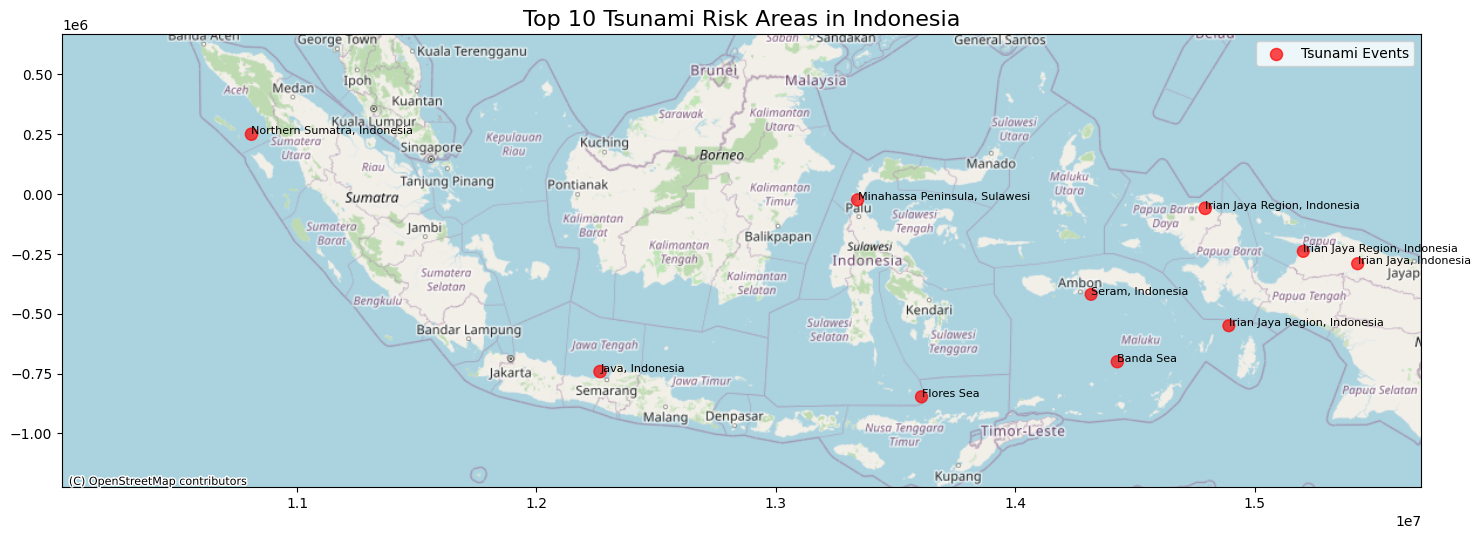

In [ ]:
# Load the dataset
file_path = "/content/Ranked_Earthquake_Data.csv"  # Adjust path as needed
earthquake_data = pd.read_csv(file_path)

# Filter for tsunami events and sort by magnitude
tsunami_data = earthquake_data[earthquake_data['tsunami'] == 1].copy()
top_10_tsunami = tsunami_data.nlargest(10, 'magnitude')

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(top_10_tsunami['longitude'], top_10_tsunami['latitude'])]
gdf = gpd.GeoDataFrame(top_10_tsunami, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator for plotting with Contextily
gdf = gdf.to_crs(epsg=3857)

# Plot the data
fig, ax = plt.subplots(figsize=(15, 15))  # Adjusted figure size for better visibility
gdf.plot(ax=ax, color='red', markersize=gdf['magnitude'] * 10, alpha=0.7, label='Tsunami Events')

# Set extent to cover Indonesia
minx, miny, maxx, maxy = [90.0, -11.0, 141.0, 6.0]  # Approximate bounding box of Indonesia
ax.set_xlim(minx * 111319.5, maxx * 111319.5)  # Convert degrees to meters
ax.set_ylim(miny * 111319.5, maxy * 111319.5)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

# Annotate with event details
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['location']):
    ax.text(x, y, label, fontsize=8, color='black')

# Add title and legend
ax.set_title("Top 10 Tsunami Risk Areas in Indonesia", fontsize=16)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


Model Building

In [ ]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    f1_score
)
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore", FutureWarning)



# Define features and target
features = ['depth', 'azimuth_gap', 'phasecount', 'latitude', 'longitude']
X = df[features]
y = df['tsunami']

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\n[INFO] Distribution of training data before balancing:")
print(y_train.value_counts())

# Step 2: Downsampling
rus = RandomUnderSampler(sampling_strategy={0: 219, 1: 219}, random_state=42)
X_train_down, y_train_down = rus.fit_resample(X_train, y_train)
print("\n[INFO] Distribution of training data after downsampling:")
print(pd.Series(y_train_down).value_counts())

# Step 3: SMOTE to increase minority class
smote = SMOTE(sampling_strategy={0: 319, 1: 319}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_down, y_train_down)
print("\n[INFO] Distribution after SMOTE (training):")
print(pd.Series(y_train_smote).value_counts())

print(f"[INFO] Number of test data: {len(X_test)}")

# Step 4: Adjust the test data distribution to be balanced
tsunami_data = X_test[y_test == 1]
non_tsunami_data = X_test[y_test == 0]

# Sample the non-tsunami data to match tsunami data size (x2, for instance)
n_non_tsunami_sample = len(tsunami_data) * 2
if n_non_tsunami_sample > len(non_tsunami_data):
    # If there's not enough non-tsunami data, limit it
    n_non_tsunami_sample = len(non_tsunami_data)

non_tsunami_sampled = non_tsunami_data.sample(
    n=n_non_tsunami_sample,
    random_state=42,
    replace=False
)

# Recombine the balanced test set
X_test_balanced = pd.concat([tsunami_data, non_tsunami_sampled])
y_test_balanced = y_test.loc[X_test_balanced.index]

# Check the new test data distribution
print("\n[INFO] Distribution of the test data after balancing:")
print(y_test_balanced.value_counts())

# Step 5: Data Scaling
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

# Step 6: Model dictionary with more regularization
models = {
    "Logistic Regression": LogisticRegression(
        random_state=42, max_iter=5000, class_weight='balanced'
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42, class_weight='balanced'
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42, class_weight='balanced'
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

# Step 7: Cross-Validation function
def cross_validate_model(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results = cross_val_score(model, X, y, scoring='roc_auc', cv=skf)
    print(f"\nCross-Validation ROC-AUC (mean): {results.mean():.4f} (std: {results.std():.4f})")

# Step 8: Model Evaluation (Focus on Tsunami)
def evaluate_model(model, X_test, y_test):
    model.fit(X_train_smote_scaled, y_train_smote)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Adjust threshold to focus on tsunami
    threshold = 0.3
    y_pred = (y_proba >= threshold).astype(int)

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Classification Report
    # Use labels=[0,1] so that "No Tsunami", "Tsunami" appear as keys in output_dict
    print("\nClassification Report:")
    report_dict = classification_report(
        y_test,
        y_pred,
        labels=[0, 1],
        target_names=["No Tsunami", "Tsunami"],
        output_dict=True
    )

    # Also display the text report
    print(classification_report(
        y_test,
        y_pred,
        labels=[0, 1],
        target_names=["No Tsunami", "Tsunami"]
    ))

    # Additional metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    precision = report_dict["Tsunami"]["precision"]
    recall = report_dict["Tsunami"]["recall"]
    f1_minor = report_dict["Tsunami"]["f1-score"]

    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Precision (Tsunami): {precision:.4f}")
    print(f"Recall   (Tsunami): {recall:.4f}")
    print(f"F1-Score (Tsunami): {f1_minor:.4f}")

# Step 9: Feature Importance
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        print("\nFeature Importances:")
        print(feature_importance)
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_[0]
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
        print("\nFeature Coefficients:")
        print(coef_df)

# Step 10: Evaluate and Visualize All Models (with Cross-Validation)
for model_name, model in models.items():
    print(f"\n=== Evaluating {model_name} ===")
    try:
        cross_validate_model(model, X_train_smote_scaled, y_train_smote)
        evaluate_model(model, X_test_balanced_scaled, y_test_balanced)
    except Exception as e:
        print(f"[ERROR] Error evaluating {model_name}: {e}")
        continue

    # Show feature importance if available
    get_feature_importance(model, features)

# Step 11: Display Actual vs Predicted Summary (Focus on Tsunami)
def summarize_predictions(model, model_name, X_test, y_test):
    model.fit(X_train_smote_scaled, y_train_smote)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Adjust threshold for tsunami focus
    threshold = 0.3
    y_pred = (y_proba >= threshold).astype(int)

    tsunami_actual = y_test.sum()     # Number of actual tsunami cases
    tsunami_predicted = y_pred.sum()  # Number of predicted tsunami cases

    print(f"\n=== {model_name} Prediction Summary ===")
    print(f"Tsunami Actual: {tsunami_actual}")
    print(f"Tsunami Predicted: {tsunami_predicted}")

# Evaluate all models and display the summary
for model_name, model in models.items():
    print(f"\n=== Summary Evaluation for {model_name} ===")
    try:
        summarize_predictions(model, model_name, X_test_balanced_scaled, y_test_balanced)
    except Exception as e:
        print(f"[ERROR] Error summarizing predictions for {model_name}: {e}")
        continue



[INFO] Distribution of training data before balancing:
tsunami
0    93380
1      219
Name: count, dtype: int64

[INFO] Distribution of training data after downsampling:
tsunami
0    219
1    219
Name: count, dtype: int64

[INFO] Distribution after SMOTE (training):
tsunami
0    319
1    319
Name: count, dtype: int64
[INFO] Number of test data: 23400

[INFO] Distribution of the test data after balancing:
tsunami
0    110
1     55
Name: count, dtype: int64

=== Evaluating Logistic Regression ===

Cross-Validation ROC-AUC (mean): 0.8487 (std: 0.0219)

Confusion Matrix:
[[55 55]
 [ 1 54]]

Classification Report:
              precision    recall  f1-score   support

  No Tsunami       0.98      0.50      0.66       110
     Tsunami       0.50      0.98      0.66        55

    accuracy                           0.66       165
   macro avg       0.74      0.74      0.66       165
weighted avg       0.82      0.66      0.66       165

ROC-AUC Score: 0.8641
Precision (Tsunami): 0.4954
Recall

DS


=== Visualizing Logistic Regression (All Features) ===


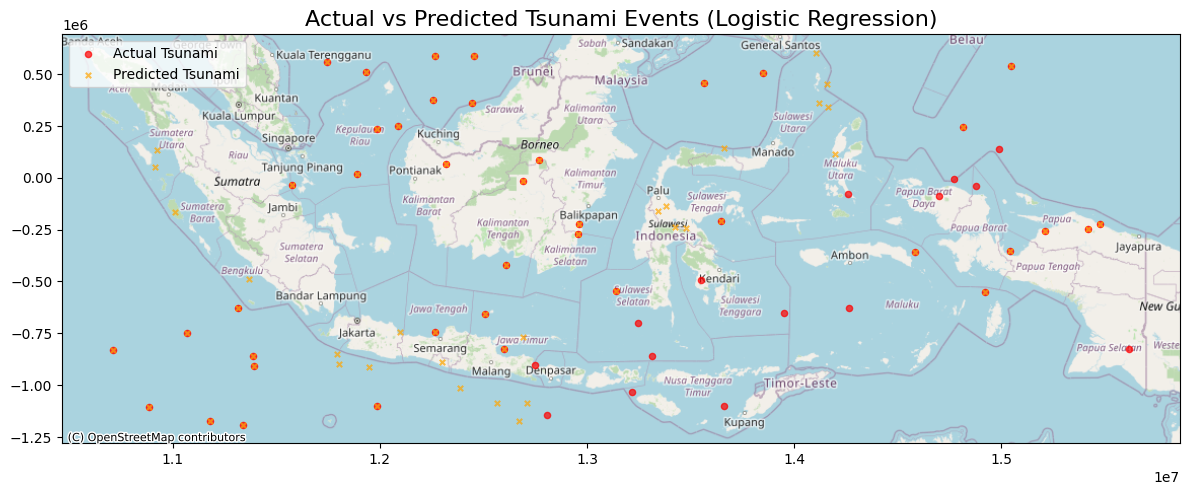

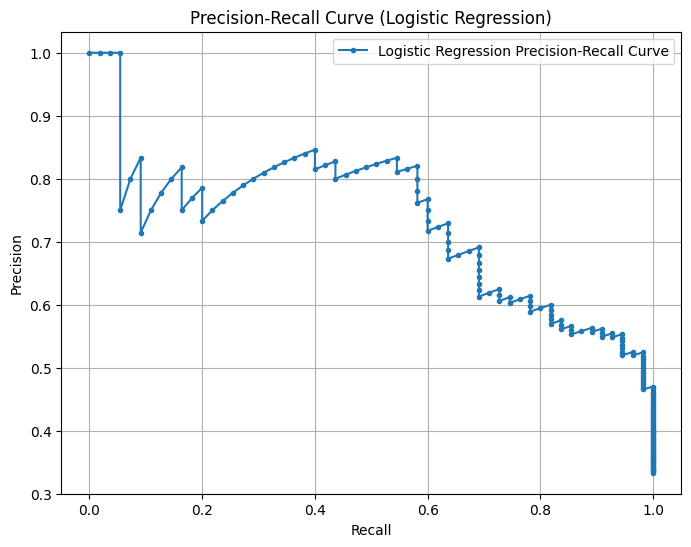


=== Visualizing Decision Tree (All Features) ===


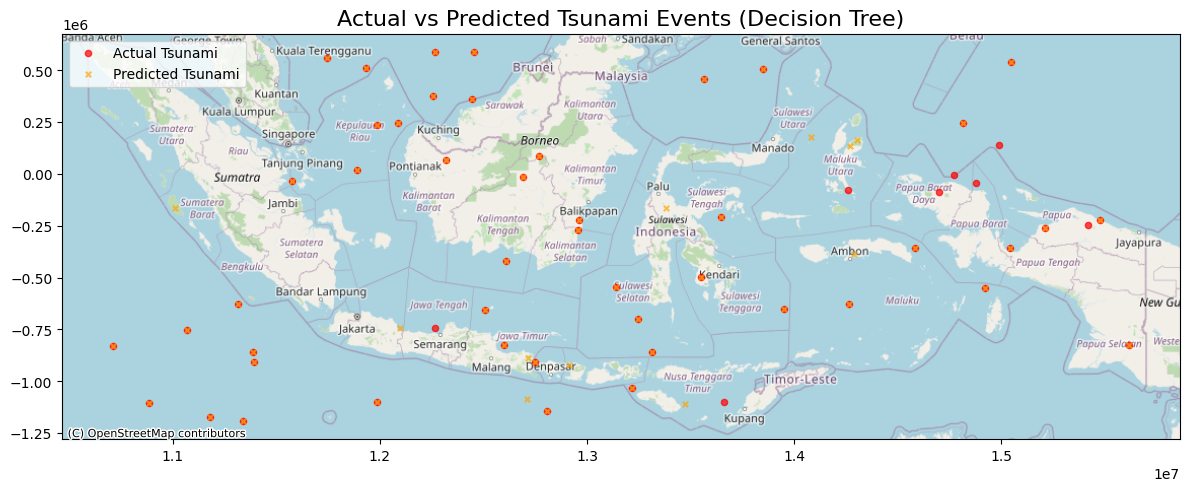

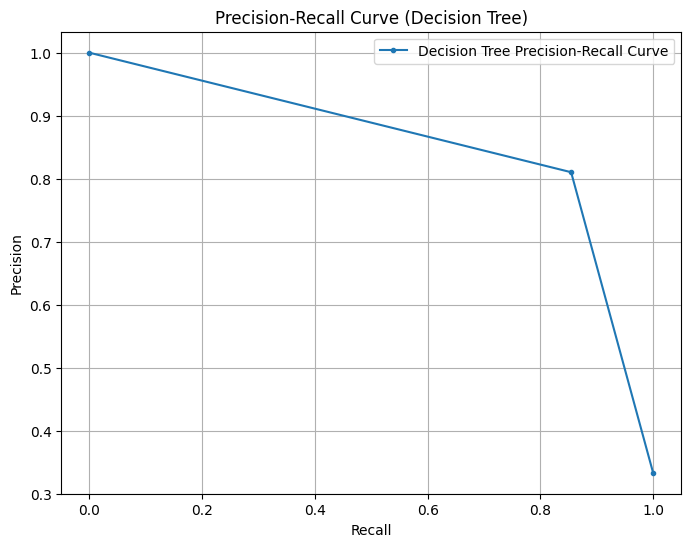


=== Visualizing Random Forest (All Features) ===


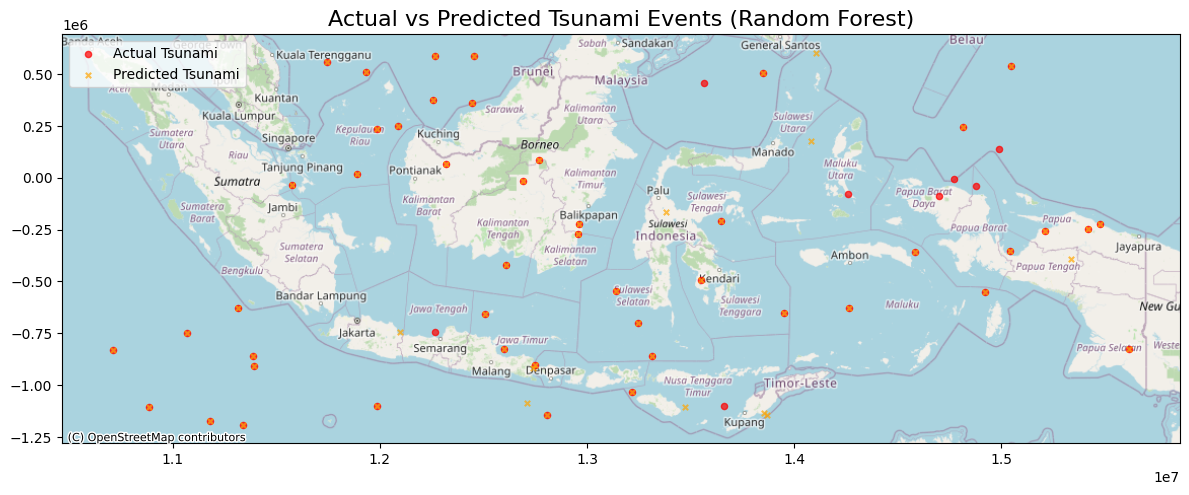

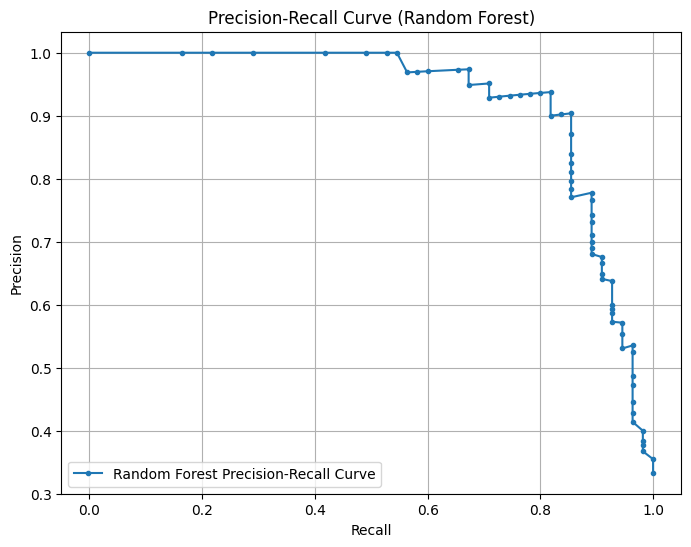


=== Visualizing Gradient Boosting (All Features) ===


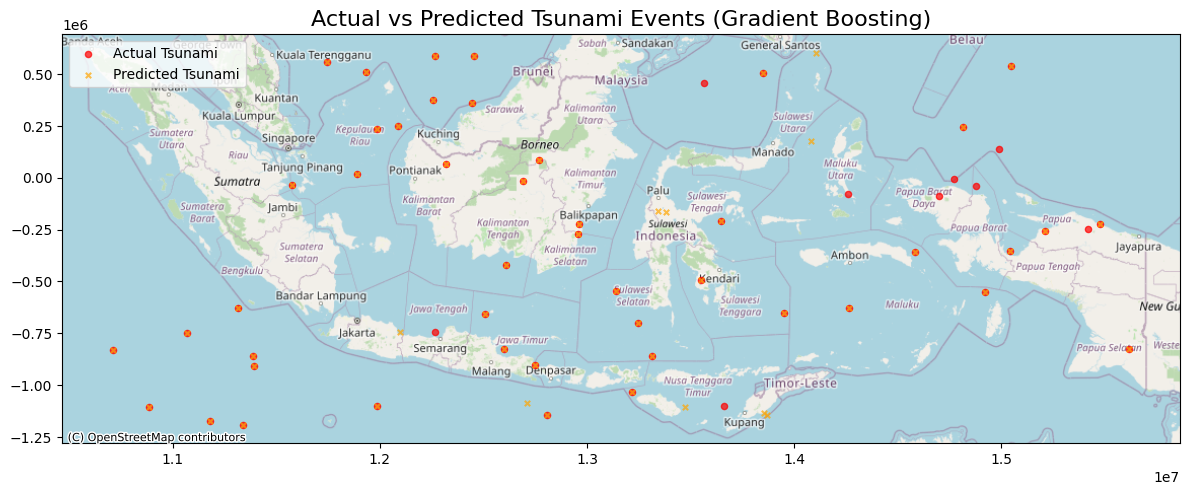

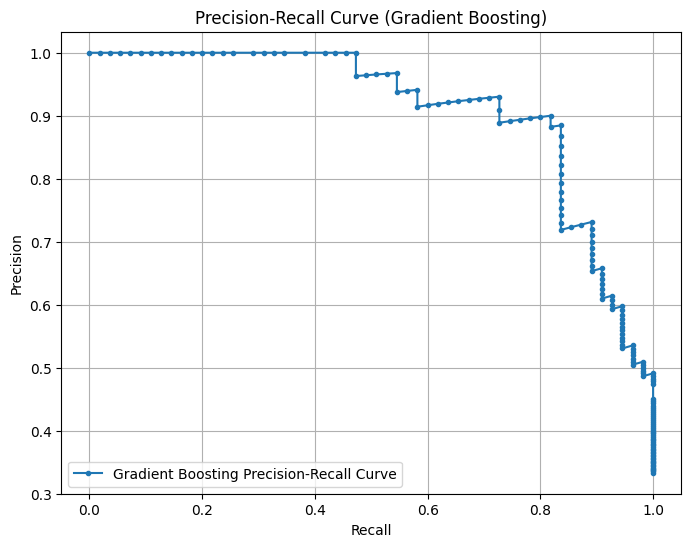

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from sklearn.metrics import precision_recall_curve

# Step 1: Prepare Data for Visualization (All Features)
def prepare_geodata_full(model, X_test_scaled, X_test, label):
    predicted = model.predict(X_test_scaled)
    X_test_copy = X_test.copy()  # Keep all original features
    X_test_copy[label] = predicted  # Add prediction as a new column
    return gpd.GeoDataFrame(
        X_test_copy,
        geometry=[Point(xy) for xy in zip(X_test['longitude'], X_test['latitude'])],
        crs="EPSG:4326"
    )

# Step 2: Plot Actual vs Predicted Tsunami Events
for model_name, model in models.items():
    print(f"\n=== Visualizing {model_name} (All Features) ===")

    # Prepare actual and predicted data (include all features)
    geo_actual = gpd.GeoDataFrame(
        X_test_balanced.assign(Tsunami=y_test_balanced),  # Assign actual labels
        geometry=[Point(xy) for xy in zip(X_test_balanced['longitude'], X_test_balanced['latitude'])],
        crs="EPSG:4326"
    )
    geo_predicted = prepare_geodata_full(model, X_test_balanced_scaled, X_test_balanced, f'{model_name}_Predicted')

    # Convert both GeoDataFrames to Web Mercator for basemap
    geo_actual = geo_actual.to_crs(epsg=3857)
    geo_predicted = geo_predicted.to_crs(epsg=3857)

    # Create simplified plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot only Actual Tsunami and Predicted Tsunami
    geo_actual[geo_actual['Tsunami'] == 1].plot(ax=ax, color='red', markersize=20, alpha=0.7, label='Actual Tsunami')
    geo_predicted[geo_predicted[f'{model_name}_Predicted'] == 1].plot(ax=ax, color='orange', markersize=15, alpha=0.7, label='Predicted Tsunami', marker='x')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

    # Set title and legend
    ax.set_title(f"Actual vs Predicted Tsunami Events ({model_name})", fontsize=16)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Step 3: Precision-Recall Curve
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_balanced_scaled)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test_balanced_scaled)
        else:
            y_proba = model.predict(X_test_balanced_scaled).astype(float)

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test_balanced, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, marker='.', label=f'{model_name} Precision-Recall Curve')
        plt.title(f"Precision-Recall Curve ({model_name})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Could not compute probability-based metrics for {model_name}: {e}")



=== Prediction Confidence Map for Logistic Regression (Filtered Ocean Points) ===


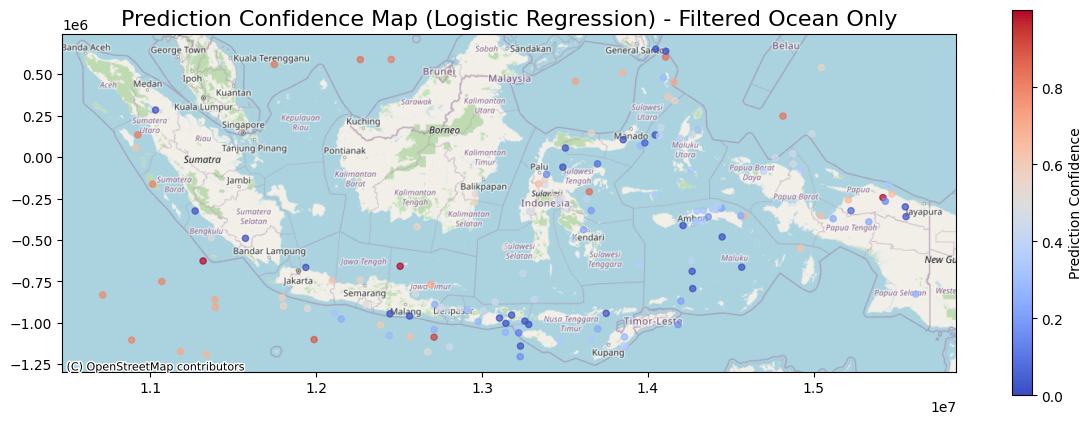


=== Prediction Confidence Map for Decision Tree (Filtered Ocean Points) ===


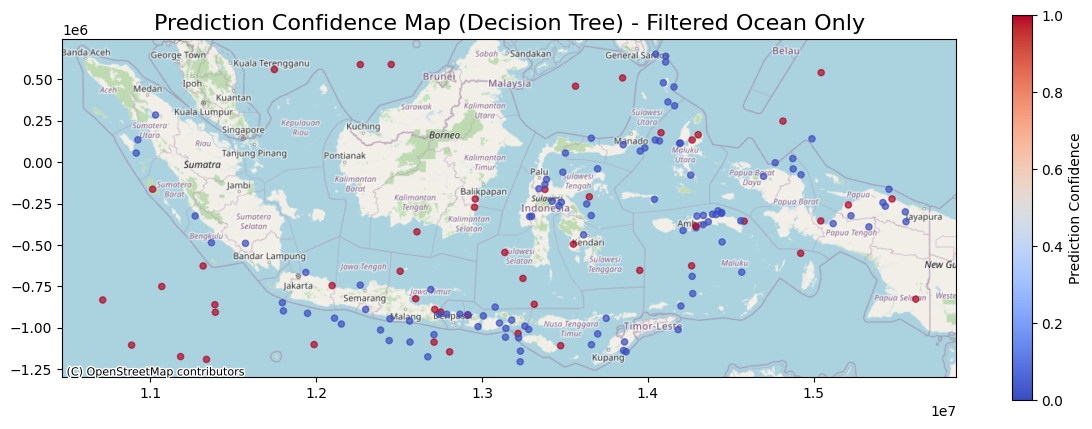


=== Prediction Confidence Map for Random Forest (Filtered Ocean Points) ===


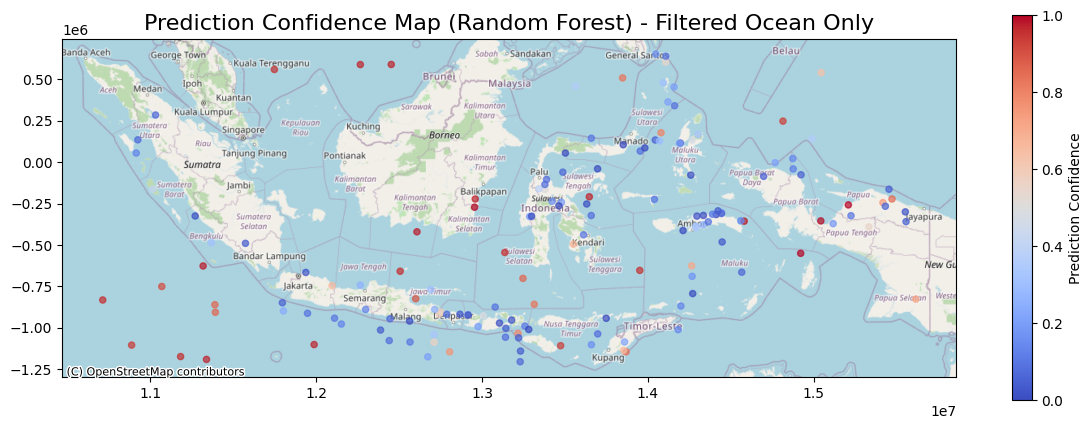


=== Prediction Confidence Map for Gradient Boosting (Filtered Ocean Points) ===


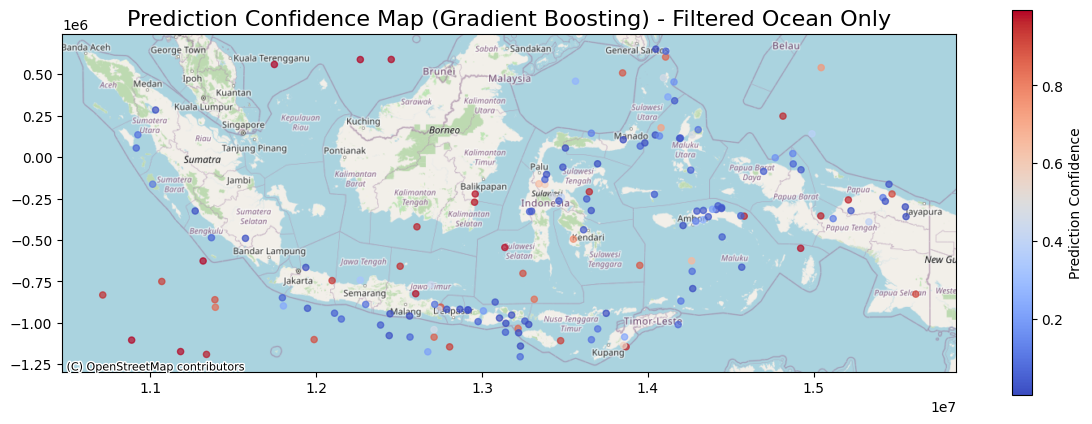

In [ ]:
# Define approximate ranges for "sea regions" (bounding box filtering)
def is_in_sea(lon, lat):
# Simple logic example: Coarse sea filter based on longitude & latitude
# Java Sea, Banda Sea, etc.
    return not (
        (95 <= lon <= 141) and (-11 <= lat <= 6) and  # Bounding box Indonesia
        (lat > -1 and lat < 5 and lon > 102 and lon < 120)  # Main land area (Sumatra-Java-Borneo)
    )

# Filter Points Outside Land
for model_name, model in models.items():
    print(f"\n=== Prediction Confidence Map for {model_name} (Filtered Ocean Points) ===")

    # Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_balanced_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_balanced_scaled)
    else:
        y_proba = model.predict(X_test_balanced_scaled).astype(float)

    # Create GeoDataFrame
    geo_confidence = gpd.GeoDataFrame(
        X_test_balanced.assign(Confidence=y_proba),
        geometry=[Point(xy) for xy in zip(X_test_balanced['longitude'], X_test_balanced['latitude'])],
        crs="EPSG:4326"
    )

    # Apply manual filter to keep only points in sea
    geo_confidence_sea = geo_confidence[
        geo_confidence.apply(lambda row: is_in_sea(row.geometry.x, row.geometry.y), axis=1)
    ].to_crs(epsg=3857)

    # Plot the filtered points
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    geo_confidence_sea.plot(
        ax=ax, column='Confidence', cmap='coolwarm', legend=True,
        markersize=20, alpha=0.7, legend_kwds={'label': "Prediction Confidence", "shrink": 0.5}
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

    ax.set_title(f"Prediction Confidence Map ({model_name})", fontsize=16)
    plt.tight_layout()
    plt.show()



=== ROC Curve for Logistic Regression ===


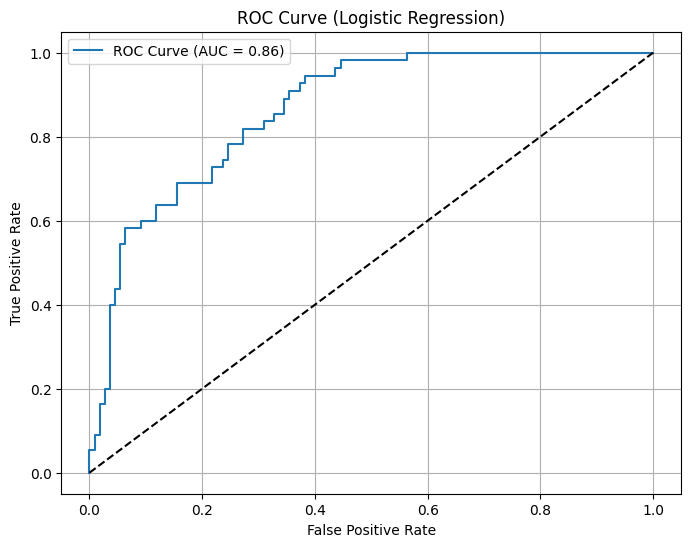


=== ROC Curve for Decision Tree ===


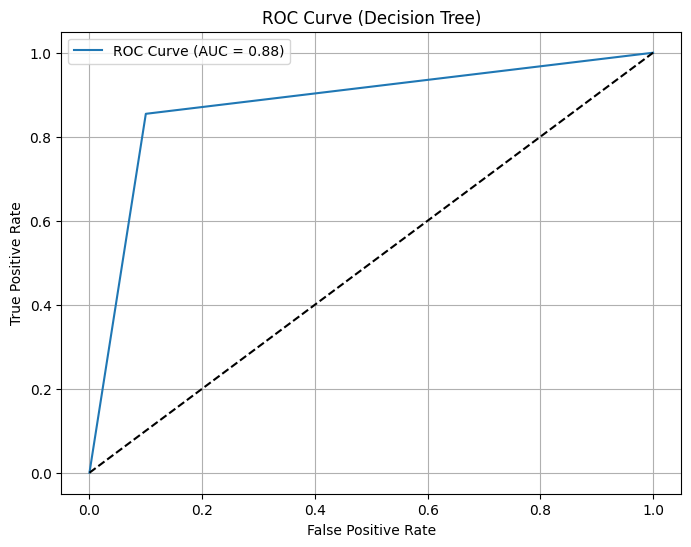


=== ROC Curve for Random Forest ===


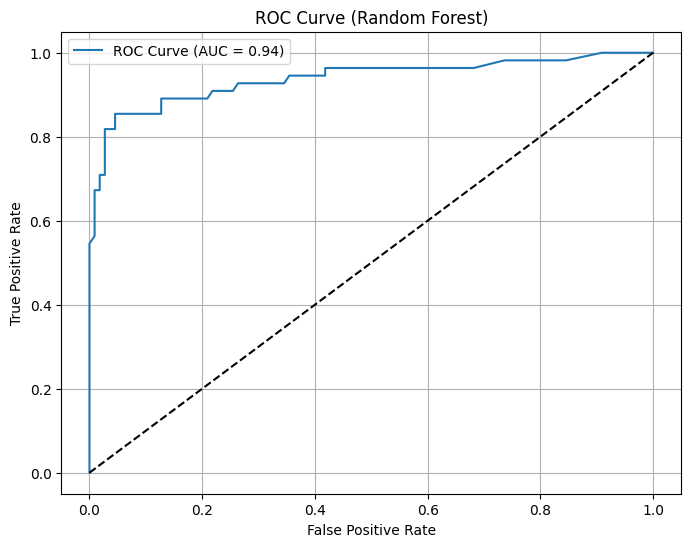


=== ROC Curve for Gradient Boosting ===


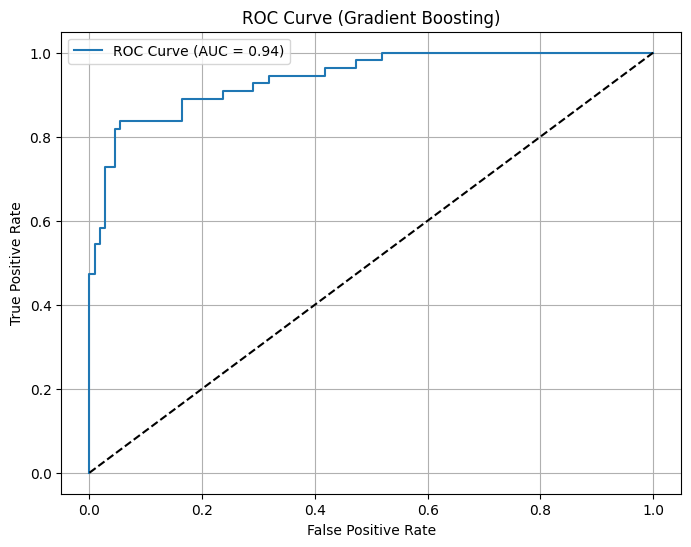

In [ ]:
from sklearn.metrics import roc_curve, auc

# Step: ROC Curve Visualization
for model_name, model in models.items():
    print(f"\n=== ROC Curve for {model_name} ===")

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_balanced_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_balanced_scaled)
    else:
        y_proba = model.predict(X_test_balanced_scaled).astype(float)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_balanced, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'ROC Curve ({model_name})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()



=== Visualizing Logistic Regression (Filtered Land Events) ===


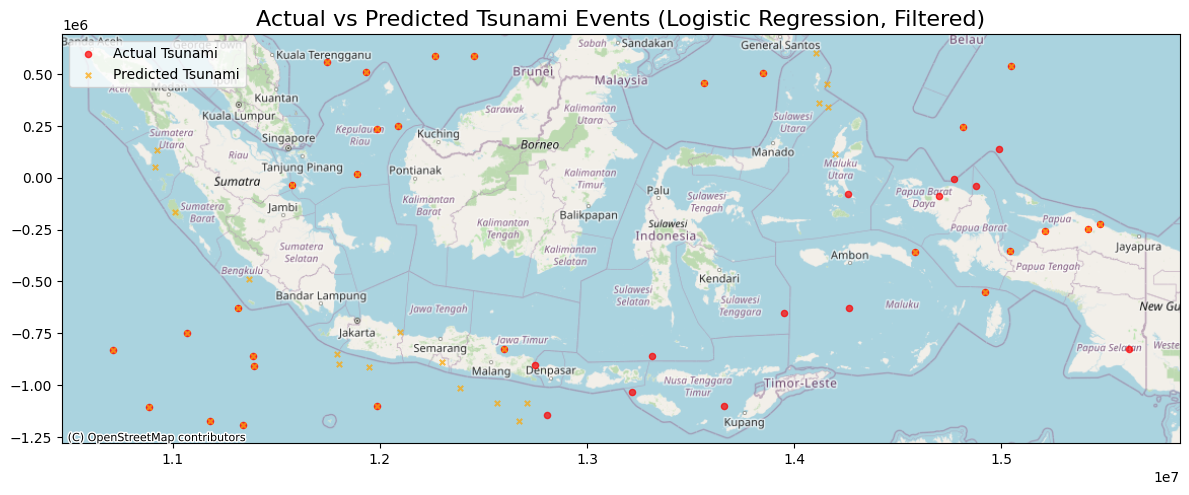


=== Visualizing Decision Tree (Filtered Land Events) ===


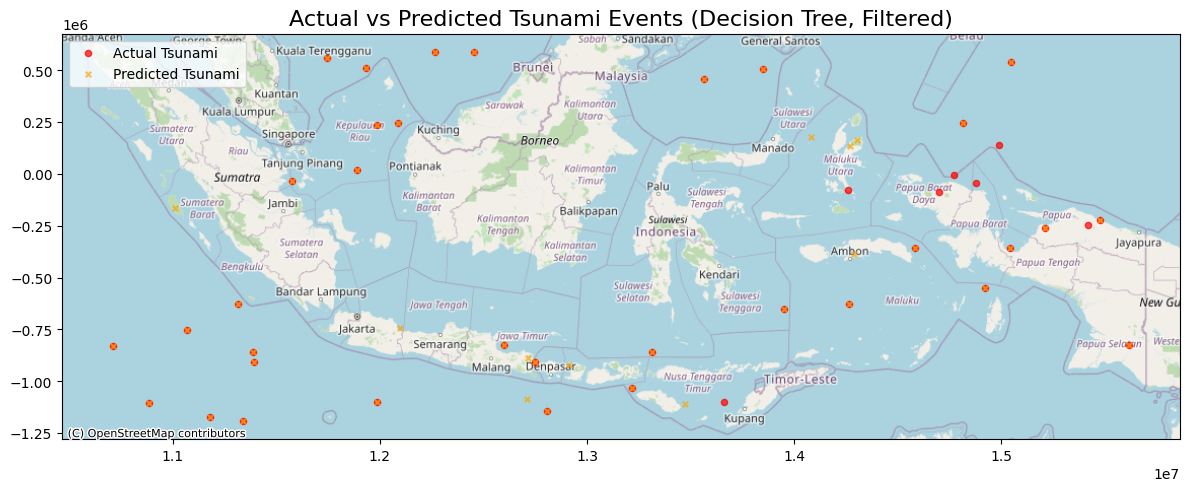


=== Visualizing Random Forest (Filtered Land Events) ===


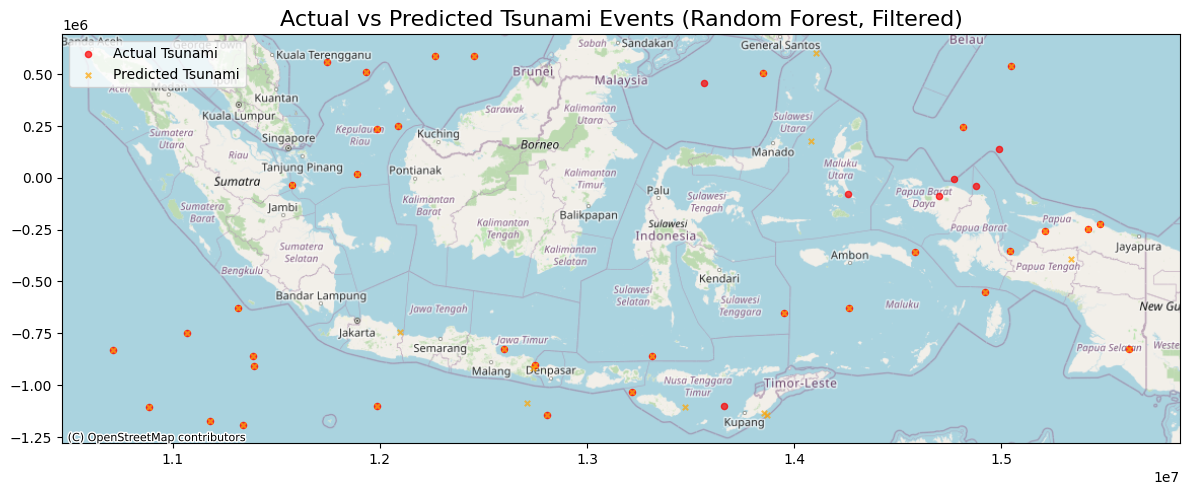


=== Visualizing Gradient Boosting (Filtered Land Events) ===


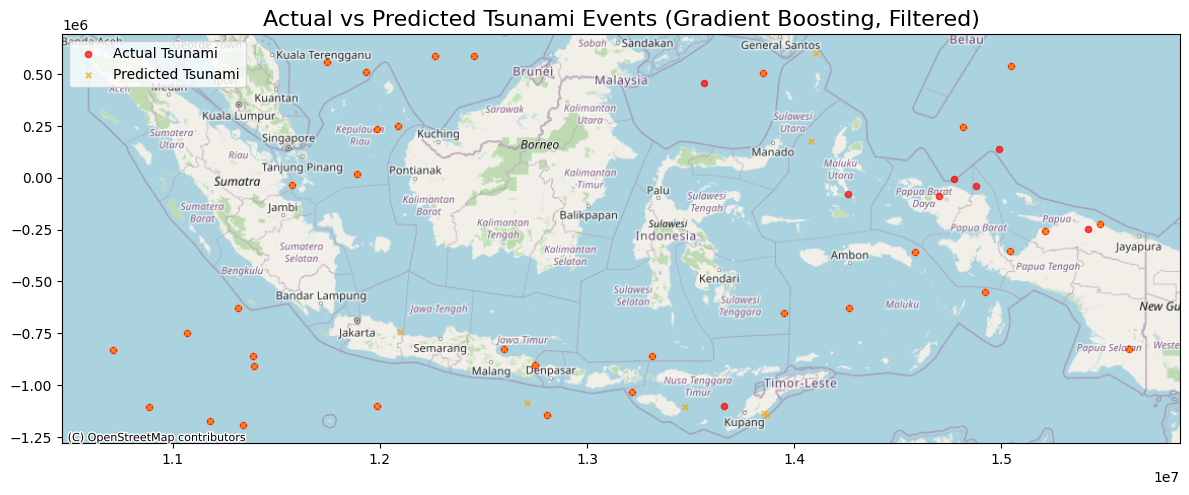

In [ ]:
# Step 1: Filter Out Tsunami Events on Land with Geographical Conditions
def filter_land_events(geo_data):
    land_conditions = (
        ((geo_data['longitude'] > 109) & (geo_data['longitude'] < 120) & (geo_data['latitude'] > -7) & (geo_data['latitude'] < 4)) |  # Kalimantan
        ((geo_data['longitude'] > 120) & (geo_data['longitude'] < 125) & (geo_data['latitude'] > -5) & (geo_data['latitude'] < 2))   # Sulawesi
    )
    return geo_data[~land_conditions]  # Retain points not matching land conditions

# Step 2: Plot Actual vs Predicted Tsunami Events
for model_name, model in models.items():
    print(f"\n=== Visualizing {model_name} (Filtered Land Events) ===")

    # Prepare actual and predicted data
    geo_actual = gpd.GeoDataFrame(
        X_test_balanced.assign(Tsunami=y_test_balanced),
        geometry=[Point(xy) for xy in zip(X_test_balanced['longitude'], X_test_balanced['latitude'])],
        crs="EPSG:4326"
    )
    geo_actual = filter_land_events(geo_actual)  # Apply land filter

    geo_predicted = prepare_geodata_full(model, X_test_balanced_scaled, X_test_balanced, f'{model_name}_Predicted')
    geo_predicted = filter_land_events(geo_predicted)  # Apply land filter

    # Convert both GeoDataFrames to Web Mercator for basemap
    geo_actual = geo_actual.to_crs(epsg=3857)
    geo_predicted = geo_predicted.to_crs(epsg=3857)

    # Create filtered plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot only Actual Tsunami and Predicted Tsunami (filtered)
    geo_actual[geo_actual['Tsunami'] == 1].plot(ax=ax, color='red', markersize=20, alpha=0.7, label='Actual Tsunami')
    geo_predicted[geo_predicted[f'{model_name}_Predicted'] == 1].plot(ax=ax, color='orange', markersize=15, alpha=0.7, label='Predicted Tsunami', marker='x')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

    # Set title and legend
    ax.set_title(f"Actual vs Predicted Tsunami Events ({model_name}, Filtered)", fontsize=16)
    ax.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

# Example filter function
def filter_land_events(geo_data):
    """
    Example logic: Remove tsunami events that fall on land
    based on some bounding-box conditions (Kalimantan & Sulawesi).
    Adjust as needed for your actual study region.
    """
    land_conditions = (
        ((geo_data['longitude'] > 109) & (geo_data['longitude'] < 120) &
         (geo_data['latitude'] > -7) & (geo_data['latitude'] < 4))   # Kalimantan
        |
        ((geo_data['longitude'] > 120) & (geo_data['longitude'] < 125) &
         (geo_data['latitude'] > -5) & (geo_data['latitude'] < 2))   # Sulawesi
    )
    return geo_data[~land_conditions]

def make_folium_cluster_map(model_name, geo_actual, geo_predicted):
    """
    Create a Folium map (centered on Indonesia) with MarkerCluster
    for both actual and predicted tsunami events in different colors.
    """

    # Adjust center for Indonesia; tweak zoom_start for broader/narrower view
    center_lat, center_lon = -2.5, 118.0
    m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Create two clusters: Actual Tsunami and Predicted Tsunami
    actual_cluster = MarkerCluster(name="Actual Tsunami").add_to(m)
    predicted_cluster = MarkerCluster(name="Predicted Tsunami").add_to(m)

    # Plot Actual Tsunami (red)
    actual_tsunami = geo_actual[geo_actual['Tsunami'] == 1]
    for idx, row in actual_tsunami.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Actual Tsunami: ID={idx}",
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(actual_cluster)

    # Plot Predicted Tsunami (orange)
    pred_tsunami = geo_predicted[geo_predicted[f'{model_name}_Predicted'] == 1]
    for idx, row in pred_tsunami.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Predicted Tsunami: ID={idx}",
            icon=folium.Icon(color='orange', icon='info-sign')
        ).add_to(predicted_cluster)

    # Add a layer control so user can toggle clusters
    folium.LayerControl().add_to(m)

    # Return Folium Map object
    return m



for model_name, model in models.items():
    print(f"\n=== Visualizing with Folium for {model_name} (Filtered Land Events) ===")

    # Prepare actual
    geo_actual = gpd.GeoDataFrame(
        X_test_balanced.assign(Tsunami=y_test_balanced),
        geometry=[
            Point(xy) for xy in zip(X_test_balanced['longitude'],
                                    X_test_balanced['latitude'])
        ],
        crs="EPSG:4326"
    )
    geo_actual = filter_land_events(geo_actual)

    # Prepare predicted
    geo_predicted = prepare_geodata_full(model, X_test_balanced_scaled,
                                         X_test_balanced,
                                         f'{model_name}_Predicted')
    geo_predicted = filter_land_events(geo_predicted)

    folium_map = make_folium_cluster_map(model_name, geo_actual, geo_predicted)

    display(folium_map)




=== Visualizing with Folium for Logistic Regression (Filtered Land Events) ===



=== Visualizing with Folium for Decision Tree (Filtered Land Events) ===



=== Visualizing with Folium for Random Forest (Filtered Land Events) ===



=== Visualizing with Folium for Gradient Boosting (Filtered Land Events) ===
